<a href="https://colab.research.google.com/github/juanarango220485/FSS-CNN/blob/master/Speckle_regression_training_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Speckle regression training**
In this code a convolutional neural network is trained for temperature regression from fiber optic specklegrams. The synthetic [[1]](https://doi.org/10.18287/2412-6179-CO-852) specklegram dataset used in this code can be found in [Kaggle](https://doi.org/10.34740/kaggle/dsv/3583524). A physical perturbation on the fiber modifies the speckle pattern, so the network is trained to identify changes in the specklegram that correspond to perturbations on the fiber (in this case temperature).<br><br>




**Authors:** *Juan Arango, Victor Aristizabal, Francisco Velez, Juan Carrasquilla, Jorge Gomez, Jairo Quijano, and Jorge Herrera-Ramirez*
<br>
<sub>[1] J. D. Arango et al., “Numerical study using finite element method for the thermal response of fiber specklegram sensors with changes in the length of the sensing zone,” Comput. Opt., 2021.</sub>

**Note: This notebook is intended primarily for reading, if you want you can run it but keep in mind that it will take some time to train. Or you can run instead ["Speckle_regression_prediction_"](https://colab.research.google.com/drive/18K28QmZ8jOqPBWPyj5OZCeRoG3bAw6yg?usp=sharing) which is already trained and prepared for prediction with the network.**<br><br>





### **1**. Importing all the required libraries
For the mathematical functions, proccesing, neural network creation and plotting.

In [ ]:
import sys
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential                           
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, Input  
from tensorflow.keras.layers import  Conv2D, MaxPooling2D        
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

K.clear_session()

### **2.** Importing dataset and labeling
The dataset will be further divided into train/test. The files are in .tiff format and have the following nomenclature:<br><br>

![](https://drive.google.com/uc?export=view&id=18vFeaUUS794EM4ZPwt9VVB7AEinDWpb3)

For more information about the dataset, read []

In [ ]:
!git clone https://github.com/juanarango220485/FSS-CNN.git

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab \Notebooks/FSS/CNN-FSS\ 16\ -\ Reg\ -\ ENO\ UCC

/content/drive/MyDrive/Colab Notebooks/FSS/CNN-FSS 16 - Reg - ENO UCC


In [ ]:
import glob, os
data = '/content/FSS-CNN/dataset'                                                      # folder where the speckles are
os.chdir(data)
files = []                                                              # "files" is a list (of strings) that will contain each of the NAMES of the images.
for file in glob.glob("*.tiff"):                                        # We read all .tiff files
    files.append(file)
    
    
num_datos = 601
dim = 126 # image dimension (lenght = width)
X = np.zeros(shape=[num_datos, dim, dim, 3], dtype=np.uint16)           # We create an empty numpy array to store speckle images
y = np.zeros(shape=[num_datos])                                         # We create an empty numpy array to store the corresponding temperature labels
    

# The entire dataset is stored in the 3 channels of the variable 'X' and in 'y' the corresponding labels. 
for i in range(0,num_datos):
    ini = files[i].find('mm_')+3       # We look for the temperature value incorporated in the nomenclature of each file
    fin = files[i].find('°C')
    y[i] = float(files[i][ini:fin])    # And we extract the temperature value from the string
    X[i,:,:,0] = np.asarray(load_img(files[i], 
                                       color_mode='grayscale', target_size=(dim, dim)))
    X[i,:,:,1] = np.asarray(load_img(files[i], 
                                       color_mode='grayscale', target_size=(dim, dim)))
    X[i,:,:,2] = np.asarray(load_img(files[i], 
                                       color_mode='grayscale', target_size=(dim, dim)))

In [ ]:
# The dataset is divided into training (80%) and test (20%).
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

###**3.** Creating the CNN architecture

CNN = `c64 c64 p2` - `c256 c256 p2` - `c192 c192 p2` - `c128 c128 p2` - `d2048 d1` <br>

*   c -> convolution
*   p -> pooling
*   d -> dense





<br>

![](https://drive.google.com/uc?export=view&id=1BfwLanLKUjroOhui2fItOqjXF1l5TgA9)

In [ ]:
def CNN_FSS(lr):                                                                                # We create a function in which we can do several learning rate tests on our model
    
    cnn = Sequential()
    cnn.add(Conv2D(64, (3, 3), padding ="same", input_shape=(dim, dim, 3), activation='relu'))  # A 64-channel convolution block is added, with a 3x3 pixel filter and ReLU-type activation (so for all following blocks).
    cnn.add(Conv2D(64, (3, 3), padding ="same"))                                                 
    cnn.add(MaxPooling2D(pool_size=(2, 2)))                                                     # A maxpooling block with 2x2 pixel filter is added. 
    
    cnn.add(Conv2D(256, (3, 3), padding ="same"))
    cnn.add(Conv2D(256, (3, 3), padding ="same"))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    cnn.add(Conv2D(192, (3, 3), padding ="same"))
    cnn.add(Conv2D(192, (3, 3), padding ="same"))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    cnn.add(Conv2D(128, (3, 3), padding ="same"))
    cnn.add(Conv2D(128, (3, 3), padding ="same"))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    cnn.add(Flatten())                                      # The 'flatten' operation is performed, which converts the feature maps into a single feature vector.
    cnn.add(Dense(2048, activation='relu'))                 # A hidden layer is added to the dense network of 2048 neurons with ReLU activation.                                         
    cnn.add(Dropout(0.5))                                   # 50% dropout is performed (randomly turns off half of the neurons to avoid overfitting).
    cnn.add(Dense(1, activation='linear'))                  # We have a single output neuron with linear activation for temperature regression.
    
    cnn.compile(loss='mean_squared_error',                      # We use for the loss function the mean square error
                optimizer=optimizers.Adam(learning_rate=lr),    # We use the optimizer 'Adam' with the input learning rate in the function
                metrics=['accuracy'])
    return cnn

###**4.** Training the model

In [ ]:
cnn = CNN_FSS(0.00008)        # Learning Rate of 8e-5 found experimentally (best performance)
history = cnn.fit(X_train, y_train, epochs = 300, validation_split = 0.2, verbose = 1)    # 300 training epochs, 20% of the training data were left for validation.

Epoch 1/300
12/12 [==============================] - 39s 303ms/step - loss: 934.6107 - accuracy: 0.0000e+00 - val_loss: 57.0292 - val_accuracy: 0.0000e+00
Epoch 2/300
12/12 [==============================] - 3s 285ms/step - loss: 87.4330 - accuracy: 0.0000e+00 - val_loss: 26.3400 - val_accuracy: 0.0000e+00
Epoch 3/300
12/12 [==============================] - 3s 282ms/step - loss: 53.2525 - accuracy: 0.0000e+00 - val_loss: 7.1259 - val_accuracy: 0.0000e+00
Epoch 4/300
12/12 [==============================] - 3s 285ms/step - loss: 33.4579 - accuracy: 0.0000e+00 - val_loss: 6.7049 - val_accuracy: 0.0000e+00
Epoch 5/300
12/12 [==============================] - 3s 287ms/step - loss: 29.8729 - accuracy: 0.0000e+00 - val_loss: 14.0527 - val_accuracy: 0.0000e+00
Epoch 6/300
12/12 [==============================] - 3s 285ms/step - loss: 24.3718 - accuracy: 0.0000e+00 - val_loss: 2.2145 - val_accuracy: 0.0000e+00
Epoch 7/300
12/12 [==============================] - 3s 283ms/step - loss: 21.6945 

In [ ]:
# We save the model created and the weights obtained in the training.
cnn.save('model.h5')
cnn.save_weights('weights.h5')

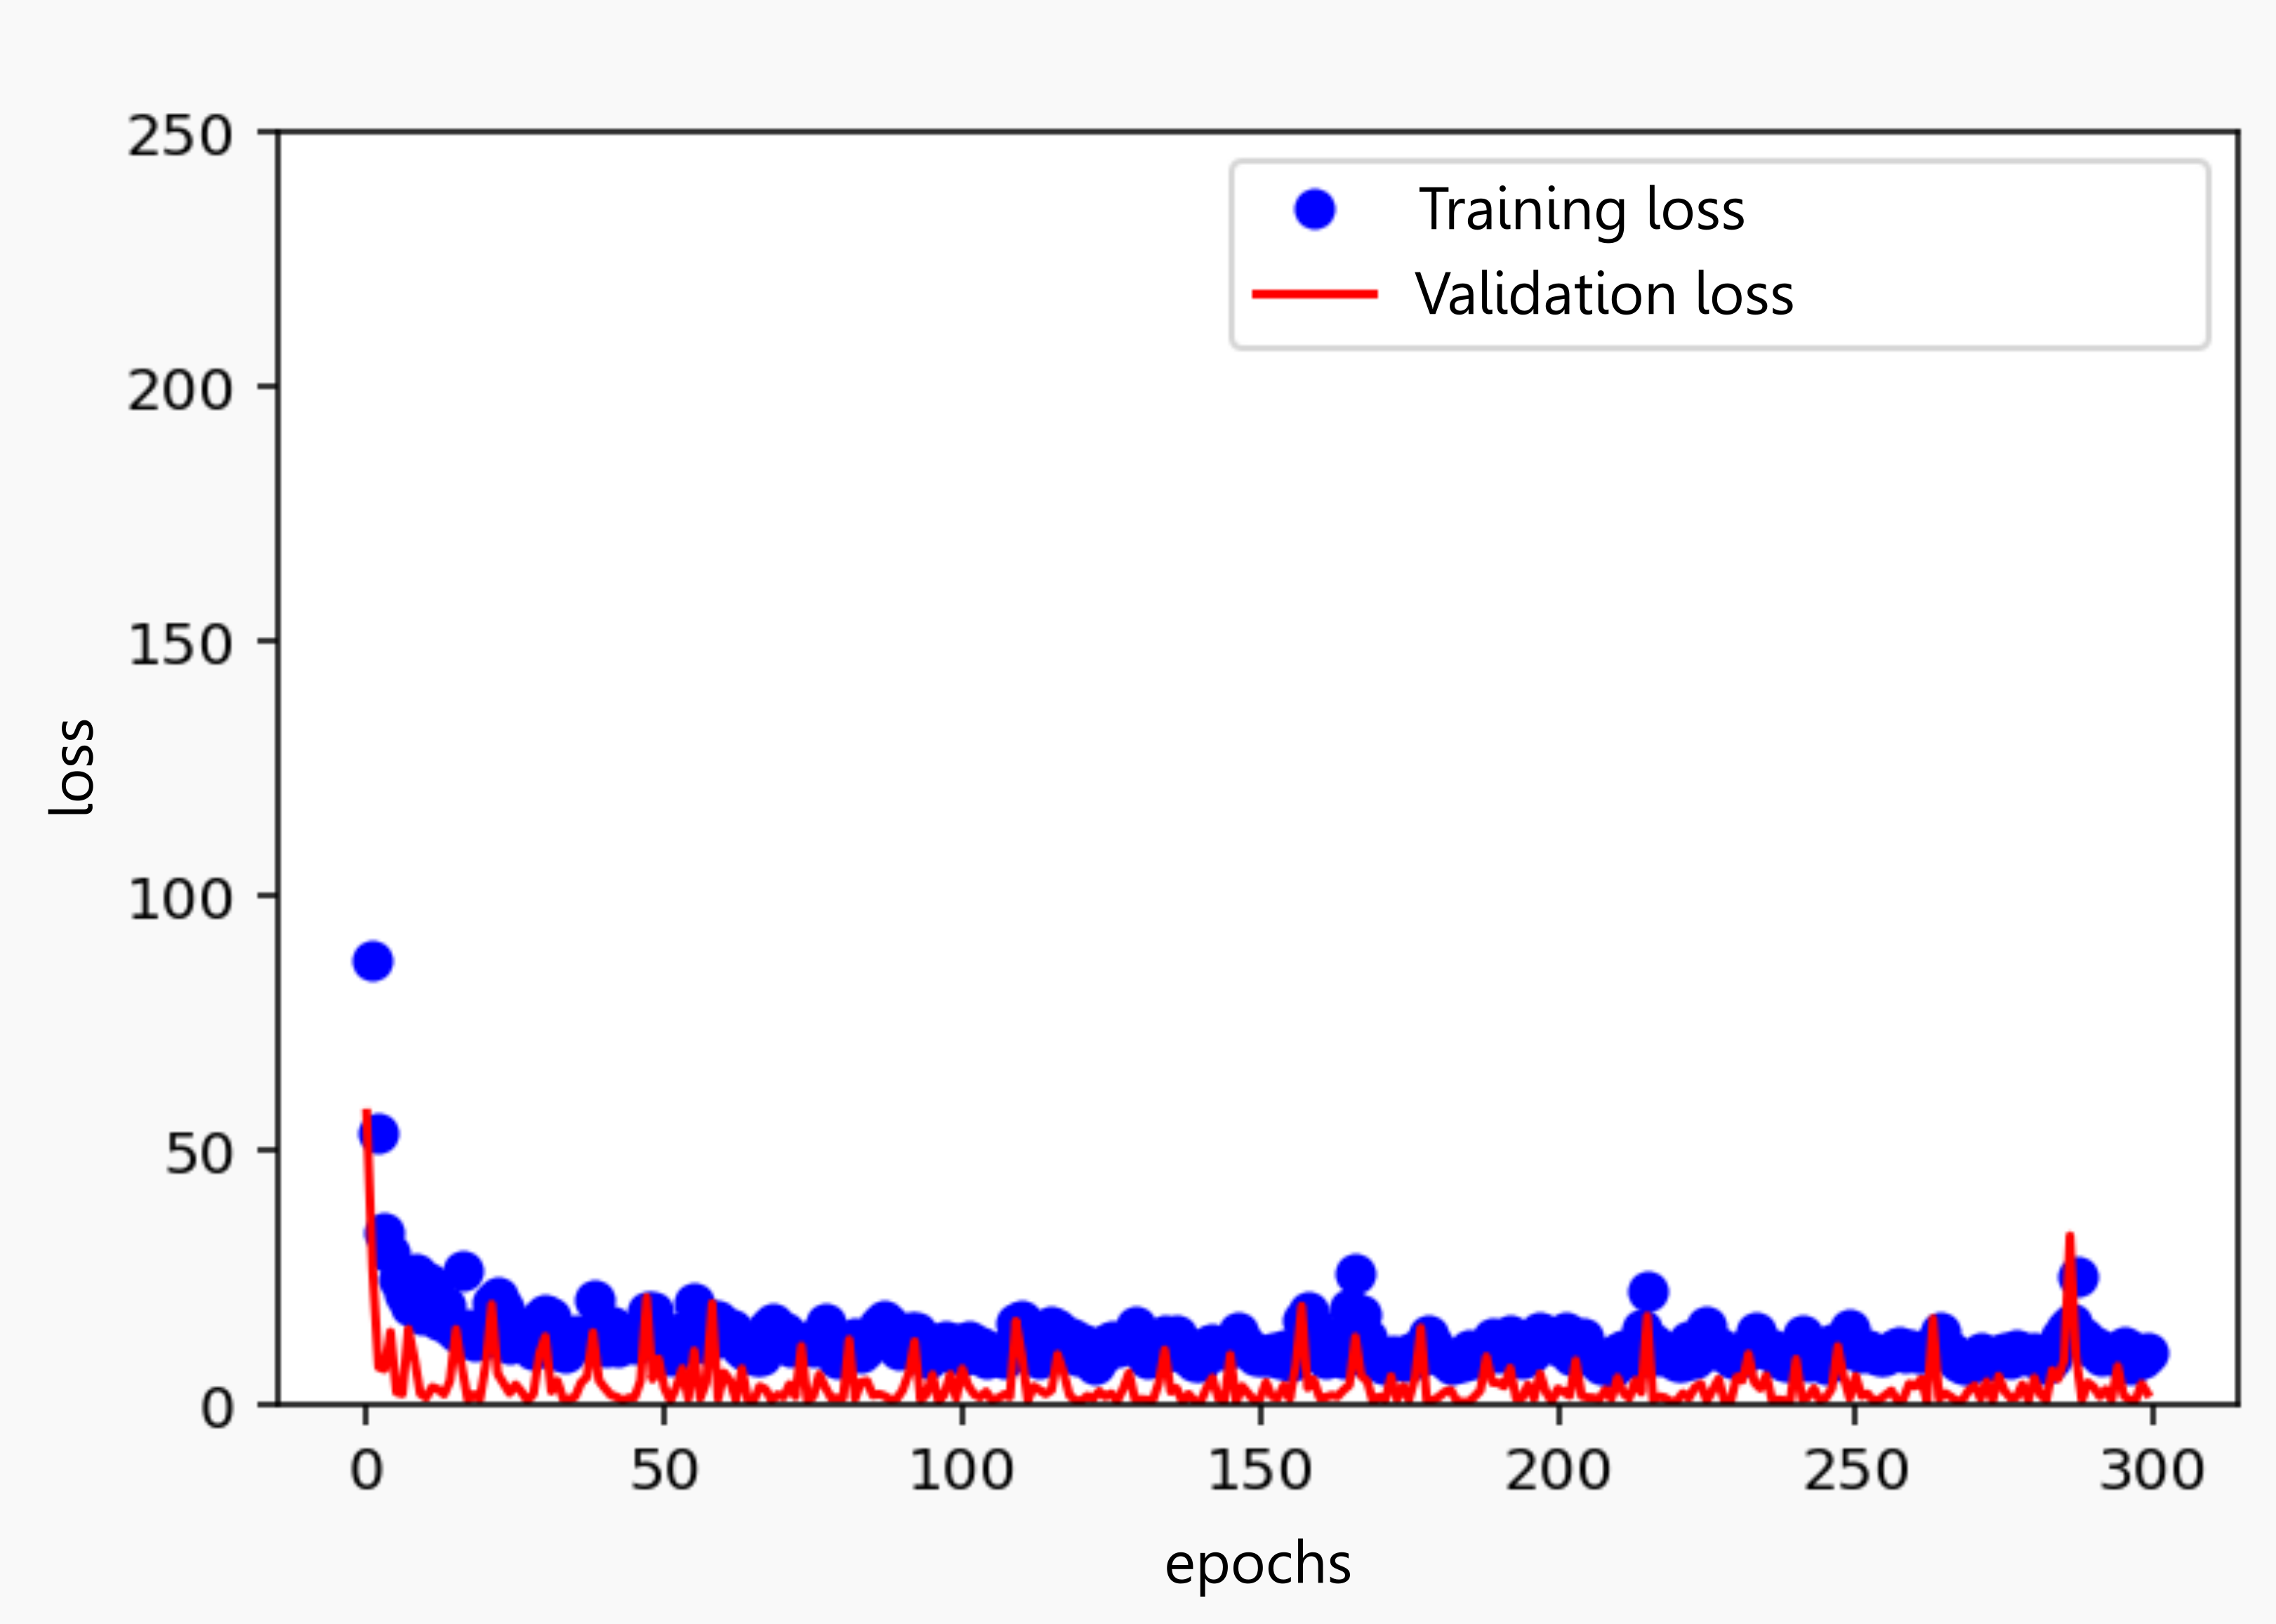

In [ ]:
# We plot training and validation loss
plt.figure()
plt.ylim([0, 250])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(history.history['loss'],'bo')
plt.plot(history.history['val_loss'],'r')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')

In [ ]:
y_predict = cnn.predict(X_test).reshape((121,))       # With the trained network we predict all test specklegrams (these data are new to the network).

In [ ]:
test_array = np.array([list(y_test), list(y_predict)]).T                    # test array es un array que incluye y_test y y_predict
test_array_ = test_array[test_array[:, 0].argsort()]                        # test array organizado ascendentemente para graficar solo los datos de prueba 
                                                                            # (que fueron aleatorios y no se usaron en el entrenamiento )


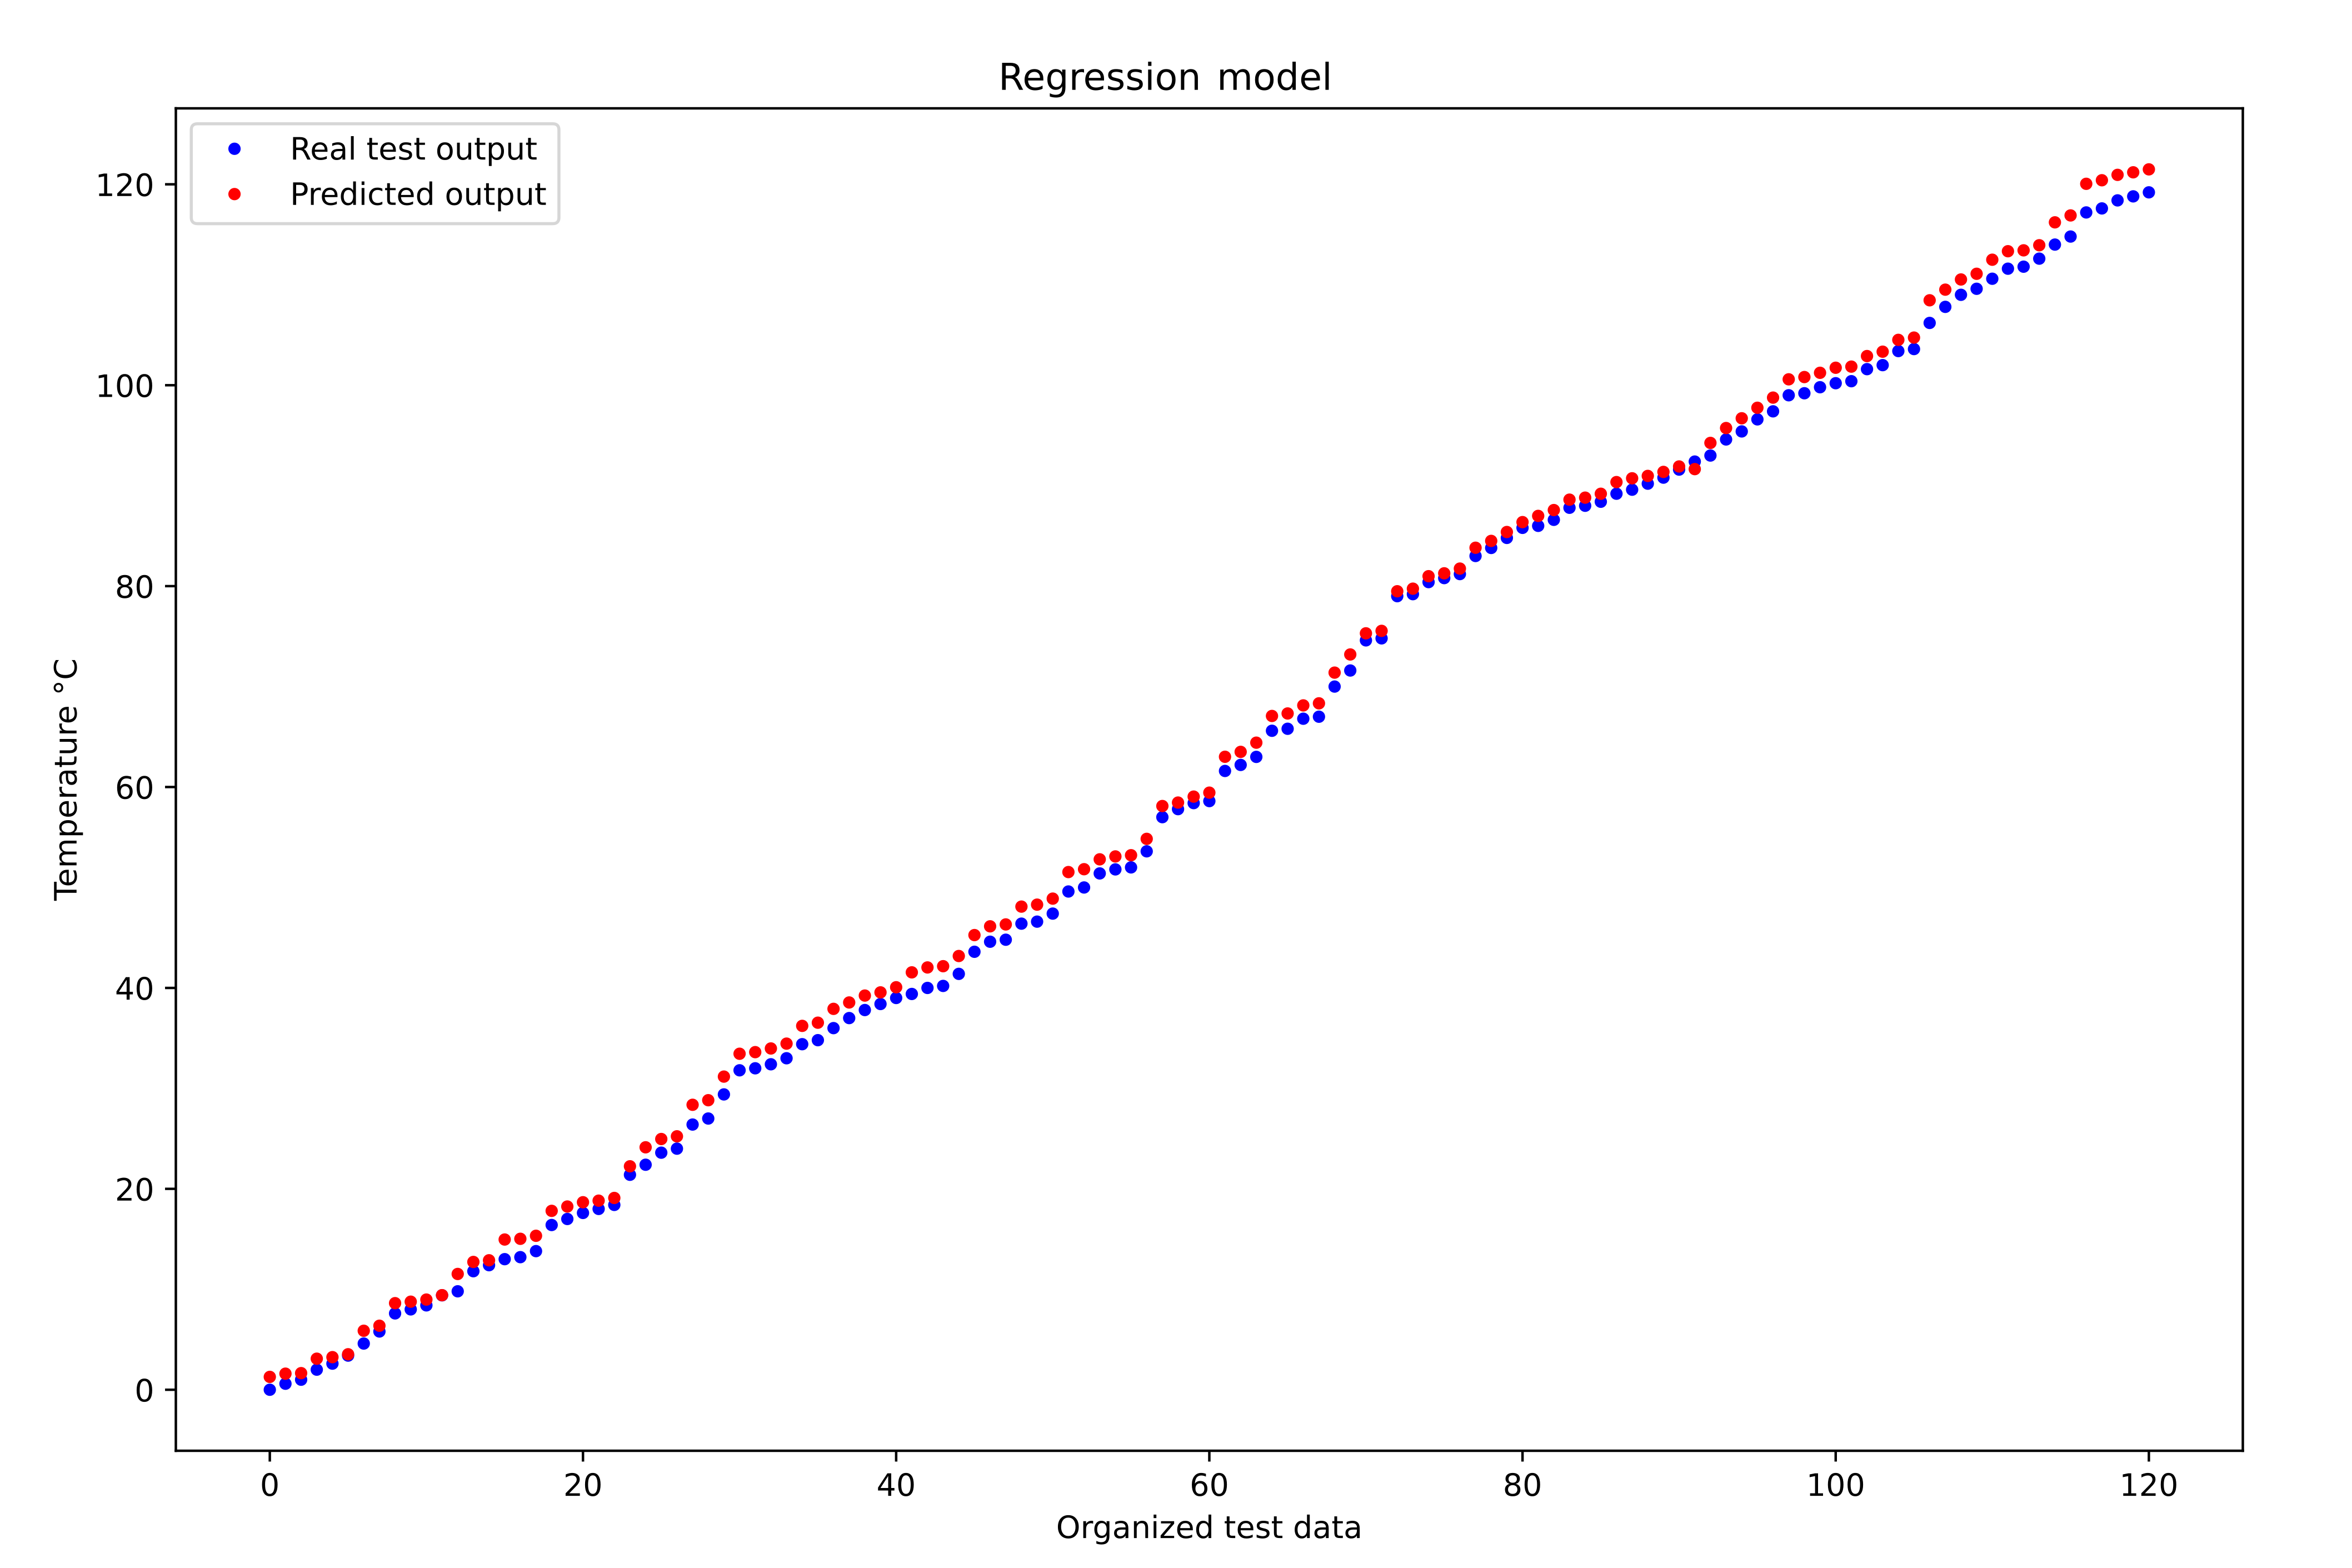

In [ ]:
# Graficamos la regresión de los datos de prueba
plt.figure(figsize=(12, 8), dpi=80)

plt.xlabel("Organized test data")
plt.ylabel("Temperature °C")
plt.title('Regression model')
plt.plot(test_array_[:,0],'bo', markersize=3)
plt.plot(test_array_[:,1],'ro', markersize=3)

plt.legend(['Real test output', 'Predicted output'], loc='best')

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import max_error as me
from sklearn.metrics import r2_score

MSE = mse(y_test, y_predict)
MAE = mae(y_test, y_predict)
RMSE = np.sqrt(MSE)
max = me(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

print("MSE: ", round(MSE, 2))
print("MAE: ", round(MAE, 2))
print("RMSE: ", round(RMSE, 2))
print("Maximun error: ", round(max, 2))
print("r2_score: ", r2)

MSE:  2.0
MAE:  1.31
RMSE:  1.42
Maximun error:  2.85
r2_score:  0.9984619093645478
